# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [8]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file ='./traffic-signs-data/train.p' 
validation_file='./traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [9]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of validation examples
n_validation = len(y_valid)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = np.array(X_test).shape[1:4]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(np.array(y_test))[-1] + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [6]:
###functions for image augmentation 

import cv2
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import glob

def augment_brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .35+np.random.uniform(low=0, high=0.65)
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def generate_transform_images(img, ang_range, size, img_class, save):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    datagen = ImageDataGenerator(
            rotation_range=ang_range,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

    prefix = 'sign_' + str(img_class) + '_'
    if save is True:
        for transformed in datagen.flow(np.array([img]), batch_size=size,
                                   save_to_dir='generated', save_prefix=prefix, save_format='jpeg'):
            return transformed
    else: 
        for transformed in datagen.flow(np.array([img]), batch_size=size):
            return transformed

def equalize_hist(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    
    # equalize the histogram of the Y channel only
    img_yuv[:,:,0] = cv2.equalizeHist(np.array(img_yuv[:,:,0]).astype(np.uint8))
    
    #apply contrast limited adaptive histogram equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2,2))
    cl1 = clahe.apply(img_yuv[:,:,0])
    return cl1

def create_train_batch(batch_x, batch_y, size ,augment_percent=1 ,extra_data_per_element=9):
    for i in range(size): 
        batch_x[i] = equalize_hist(batch_x[i])
        transformed_img = generate_transform_images(batch_x[i], 30, extra_data_per_element, batch_y[i], False)
        batch_x = np.append(transformed_img, batch_x, axis=0)
        batch_y = np.append(np.array(batch_y[i] * extra_data_per_element), batch_y, axis=0)
            
    batch_x, batch_y = shuffle(batch_x, batch_y)
    
    return batch_x, batch_y

def create_extra_data (full_x, full_y, start_index ,data_slice, data_class, size, extra_data_limit): 
    old_size = size
    full_x, full_y = shuffle(full_x, full_y)
    index = 0 
    while size < extra_data_limit: 
        transformed_img = generate_transform_images(data_slice[index], 30, 1, data_class, True)
        full_x = np.append(transformed_img, full_x, axis=0 )
        full_y = np.append(np.array([data_class]), full_y, axis=0)
        size += 1
        index = (index + 1)%old_size
        
    return full_x, full_y
    
def process_dataset(data_x, data_y, freq, indices, u,  extra_data_limit=700):
    old_size = len(data_y)
    print("Augmenting training data...")
    mask = freq < extra_data_limit
    freq = freq[mask]
    indices = indices[mask]
    for i in range(len(indices)): 
        print(freq[i])
        data_slice = np.array(data_x[indices[i]:indices[i]+ freq[i]])
        data_x, data_y = create_extra_data(data_x , data_y , indices[i], data_slice, u[i] , freq[i], extra_data_limit) 
    
    for i in range(len(data_x)): 
        data_x[i] = equalize_hist(data_x[i])
        
    return data_x, data_y, len(data_y)

def load_extra_data(X_data, y_data):
    print("Loading generated data...")
    for filename in os.listdir('generated'):
        img = cv2.imread(os.path.join('generated',filename))
        if img is not None:
            print(filename)
            data_class = int(filename.split('_', 2)[1])
            X_data = np.append(np.array([img]),X_data, axis=0)
            y_data = np.append(np.array([data_class]), y_data, axis=0)
            print(len(X_data))
            print(len(y_data))
    print('All image successfully loaded!')
    
    return X_data, y_data, len(y_data)

def equalize_data(X_data): 
    norm_data = []
    for i in range(len(X_data)):
        print(i)
        norm_data = np.append([equalize_hist(np.array(X_data[i]))], norm_data )
        
    print("done!")
    return X_data

Using TensorFlow backend.


Loading generated data...
sign_42__0_2823.jpeg
34800
34800
sign_34__0_711.jpeg
34801
34801
sign_19__0_4912.jpeg
34802
34802
sign_19__0_4841.jpeg
34803
34803
sign_39__0_4218.jpeg
34804
34804
sign_21__0_1774.jpeg
34805
34805
sign_21__0_6692.jpeg
34806
34806
sign_36__0_6264.jpeg
34807
34807
sign_22__0_3164.jpeg
34808
34808
sign_40__0_6615.jpeg
34809
34809
sign_39__0_3540.jpeg
34810
34810
sign_24__0_9490.jpeg
34811
34811
sign_34__0_4956.jpeg
34812
34812
sign_22__0_9868.jpeg
34813
34813
sign_23__0_3310.jpeg
34814
34814
sign_41__0_3979.jpeg
34815
34815
sign_29__0_7148.jpeg
34816
34816
sign_37__0_7081.jpeg
34817
34817
sign_34__0_7220.jpeg
34818
34818
sign_0__0_129.jpeg
34819
34819
sign_42__0_9624.jpeg
34820
34820
sign_41__0_1082.jpeg
34821
34821
sign_30__0_4653.jpeg
34822
34822
sign_29__0_1714.jpeg
34823
34823
sign_29__0_6287.jpeg
34824
34824
sign_37__0_9999.jpeg
34825
34825
sign_32__0_3963.jpeg
34826
34826
sign_32__0_6320.jpeg
34827
34827
sign_39__0_9172.jpeg
34828
34828
sign_42__0_544.jpeg


35049
35049
sign_0__0_9747.jpeg
35050
35050
sign_40__0_1219.jpeg
35051
35051
sign_21__0_9503.jpeg
35052
35052
sign_21__0_5782.jpeg
35053
35053
sign_0__0_4397.jpeg
35054
35054
sign_21__0_2732.jpeg
35055
35055
sign_30__0_5512.jpeg
35056
35056
sign_32__0_5525.jpeg
35057
35057
sign_26__0_8649.jpeg
35058
35058
sign_41__0_4407.jpeg
35059
35059
sign_34__0_6273.jpeg
35060
35060
sign_16__0_4843.jpeg
35061
35061
sign_21__0_7796.jpeg
35062
35062
sign_42__0_8402.jpeg
35063
35063
sign_27__0_6147.jpeg
35064
35064
sign_39__0_2457.jpeg
35065
35065
sign_40__0_9961.jpeg
35066
35066
sign_6__0_8130.jpeg
35067
35067
sign_19__0_4720.jpeg
35068
35068
sign_30__0_2151.jpeg
35069
35069
sign_39__0_3762.jpeg
35070
35070
sign_27__0_5045.jpeg
35071
35071
sign_30__0_9335.jpeg
35072
35072
sign_28__0_7737.jpeg
35073
35073
sign_29__0_3949.jpeg
35074
35074
sign_0__0_1839.jpeg
35075
35075
sign_20__0_4986.jpeg
35076
35076
sign_39__0_8204.jpeg
35077
35077
sign_42__0_3632.jpeg
35078
35078
sign_15__0_3794.jpeg
35079
35079
si

35301
35301
sign_24__0_4391.jpeg
35302
35302
sign_16__0_58.jpeg
35303
35303
sign_41__0_1463.jpeg
35304
35304
sign_24__0_5451.jpeg
35305
35305
sign_30__0_6868.jpeg
35306
35306
sign_23__0_4048.jpeg
35307
35307
sign_37__0_553.jpeg
35308
35308
sign_19__0_3703.jpeg
35309
35309
sign_23__0_2807.jpeg
35310
35310
sign_20__0_8281.jpeg
35311
35311
sign_27__0_6883.jpeg
35312
35312
sign_22__0_5847.jpeg
35313
35313
sign_30__0_7051.jpeg
35314
35314
sign_29__0_6639.jpeg
35315
35315
sign_34__0_594.jpeg
35316
35316
sign_21__0_8899.jpeg
35317
35317
sign_41__0_2064.jpeg
35318
35318
sign_19__0_4991.jpeg
35319
35319
sign_36__0_3337.jpeg
35320
35320
sign_36__0_532.jpeg
35321
35321
sign_24__0_5088.jpeg
35322
35322
sign_19__0_5910.jpeg
35323
35323
sign_21__0_3604.jpeg
35324
35324
sign_21__0_7341.jpeg
35325
35325
sign_20__0_1241.jpeg
35326
35326
sign_6__0_8996.jpeg
35327
35327
sign_29__0_8874.jpeg
35328
35328
sign_16__0_7055.jpeg
35329
35329
sign_29__0_1295.jpeg
35330
35330
sign_20__0_4695.jpeg
35331
35331
sign

35551
35551
sign_37__0_8717.jpeg
35552
35552
sign_20__0_7835.jpeg
35553
35553
sign_20__0_6109.jpeg
35554
35554
sign_37__0_6122.jpeg
35555
35555
sign_20__0_9213.jpeg
35556
35556
sign_0__0_6797.jpeg
35557
35557
sign_0__0_1462.jpeg
35558
35558
sign_29__0_6629.jpeg
35559
35559
sign_19__0_4776.jpeg
35560
35560
sign_28__0_541.jpeg
35561
35561
sign_39__0_3504.jpeg
35562
35562
sign_34__0_962.jpeg
35563
35563
sign_29__0_3146.jpeg
35564
35564
sign_6__0_7429.jpeg
35565
35565
sign_27__0_4955.jpeg
35566
35566
sign_22__0_420.jpeg
35567
35567
sign_34__0_5125.jpeg
35568
35568
sign_42__0_6069.jpeg
35569
35569
sign_30__0_9469.jpeg
35570
35570
sign_40__0_369.jpeg
35571
35571
sign_32__0_9774.jpeg
35572
35572
sign_20__0_7772.jpeg
35573
35573
sign_41__0_2840.jpeg
35574
35574
sign_41__0_4659.jpeg
35575
35575
sign_39__0_5141.jpeg
35576
35576
sign_41__0_5235.jpeg
35577
35577
sign_39__0_2360.jpeg
35578
35578
sign_15__0_4225.jpeg
35579
35579
sign_20__0_5740.jpeg
35580
35580
sign_21__0_361.jpeg
35581
35581
sign_1

35802
35802
sign_24__0_4615.jpeg
35803
35803
sign_42__0_7692.jpeg
35804
35804
sign_37__0_3836.jpeg
35805
35805
sign_21__0_7591.jpeg
35806
35806
sign_40__0_8342.jpeg
35807
35807
sign_20__0_2566.jpeg
35808
35808
sign_22__0_6003.jpeg
35809
35809
sign_42__0_4173.jpeg
35810
35810
sign_0__0_7414.jpeg
35811
35811
sign_21__0_9707.jpeg
35812
35812
sign_6__0_2689.jpeg
35813
35813
sign_15__0_7093.jpeg
35814
35814
sign_42__0_43.jpeg
35815
35815
sign_41__0_3555.jpeg
35816
35816
sign_26__0_1137.jpeg
35817
35817
sign_39__0_5176.jpeg
35818
35818
sign_30__0_6668.jpeg
35819
35819
sign_39__0_6677.jpeg
35820
35820
sign_26__0_4077.jpeg
35821
35821
sign_30__0_9396.jpeg
35822
35822
sign_31__0_8143.jpeg
35823
35823
sign_6__0_2172.jpeg
35824
35824
sign_36__0_6369.jpeg
35825
35825
sign_24__0_502.jpeg
35826
35826
sign_27__0_9132.jpeg
35827
35827
sign_39__0_1725.jpeg
35828
35828
sign_20__0_5851.jpeg
35829
35829
sign_29__0_8111.jpeg
35830
35830
sign_21__0_3381.jpeg
35831
35831
sign_42__0_9582.jpeg
35832
35832
sign

36054
36054
sign_19__0_8946.jpeg
36055
36055
sign_29__0_4121.jpeg
36056
36056
sign_6__0_445.jpeg
36057
36057
sign_24__0_6282.jpeg
36058
36058
sign_22__0_1916.jpeg
36059
36059
sign_30__0_866.jpeg
36060
36060
sign_42__0_6088.jpeg
36061
36061
sign_37__0_3377.jpeg
36062
36062
sign_6__0_4686.jpeg
36063
36063
sign_36__0_721.jpeg
36064
36064
sign_37__0_9476.jpeg
36065
36065
sign_28__0_4108.jpeg
36066
36066
sign_37__0_2769.jpeg
36067
36067
sign_29__0_7391.jpeg
36068
36068
sign_37__0_943.jpeg
36069
36069
sign_32__0_7003.jpeg
36070
36070
sign_16__0_9987.jpeg
36071
36071
sign_23__0_779.jpeg
36072
36072
sign_34__0_6455.jpeg
36073
36073
sign_30__0_7309.jpeg
36074
36074
sign_21__0_6708.jpeg
36075
36075
sign_41__0_1714.jpeg
36076
36076
sign_21__0_2497.jpeg
36077
36077
sign_40__0_9767.jpeg
36078
36078
sign_41__0_3149.jpeg
36079
36079
sign_34__0_5337.jpeg
36080
36080
sign_23__0_9842.jpeg
36081
36081
sign_26__0_2565.jpeg
36082
36082
sign_21__0_7600.jpeg
36083
36083
sign_36__0_6652.jpeg
36084
36084
sign_

36305
36305
sign_19__0_6426.jpeg
36306
36306
sign_19__0_4507.jpeg
36307
36307
sign_26__0_322.jpeg
36308
36308
sign_42__0_482.jpeg
36309
36309
sign_41__0_5198.jpeg
36310
36310
sign_20__0_6177.jpeg
36311
36311
sign_22__0_8383.jpeg
36312
36312
sign_16__0_2348.jpeg
36313
36313
sign_41__0_5746.jpeg
36314
36314
sign_40__0_8558.jpeg
36315
36315
sign_22__0_9023.jpeg
36316
36316
sign_27__0_9115.jpeg
36317
36317
sign_20__0_7623.jpeg
36318
36318
sign_21__0_6730.jpeg
36319
36319
sign_15__0_5345.jpeg
36320
36320
sign_21__0_6634.jpeg
36321
36321
sign_40__0_8796.jpeg
36322
36322
sign_41__0_8669.jpeg
36323
36323
sign_41__0_5167.jpeg
36324
36324
sign_29__0_2689.jpeg
36325
36325
sign_28__0_5571.jpeg
36326
36326
sign_27__0_2306.jpeg
36327
36327
sign_24__0_5585.jpeg
36328
36328
sign_32__0_7288.jpeg
36329
36329
sign_20__0_9678.jpeg
36330
36330
sign_42__0_2612.jpeg
36331
36331
sign_0__0_934.jpeg
36332
36332
sign_0__0_9537.jpeg
36333
36333
sign_20__0_6437.jpeg
36334
36334
sign_19__0_8744.jpeg
36335
36335
sig

36556
36556
sign_39__0_9352.jpeg
36557
36557
sign_16__0_4941.jpeg
36558
36558
sign_40__0_7417.jpeg
36559
36559
sign_0__0_8657.jpeg
36560
36560
sign_19__0_8194.jpeg
36561
36561
sign_36__0_3509.jpeg
36562
36562
sign_21__0_3768.jpeg
36563
36563
sign_32__0_224.jpeg
36564
36564
sign_16__0_6032.jpeg
36565
36565
sign_20__0_3701.jpeg
36566
36566
sign_41__0_6336.jpeg
36567
36567
sign_39__0_5300.jpeg
36568
36568
sign_26__0_8555.jpeg
36569
36569
sign_41__0_5276.jpeg
36570
36570
sign_28__0_2418.jpeg
36571
36571
sign_19__0_1853.jpeg
36572
36572
sign_34__0_3830.jpeg
36573
36573
sign_41__0_4666.jpeg
36574
36574
sign_20__0_19.jpeg
36575
36575
sign_21__0_2998.jpeg
36576
36576
sign_20__0_4918.jpeg
36577
36577
sign_0__0_1631.jpeg
36578
36578
sign_16__0_9760.jpeg
36579
36579
sign_16__0_9377.jpeg
36580
36580
sign_19__0_4940.jpeg
36581
36581
sign_24__0_2176.jpeg
36582
36582
sign_28__0_2315.jpeg
36583
36583
sign_19__0_3668.jpeg
36584
36584
sign_22__0_9534.jpeg
36585
36585
sign_41__0_5720.jpeg
36586
36586
sig

36807
36807
sign_41__0_2879.jpeg
36808
36808
sign_6__0_7092.jpeg
36809
36809
sign_6__0_9022.jpeg
36810
36810
sign_27__0_846.jpeg
36811
36811
sign_6__0_4564.jpeg
36812
36812
sign_23__0_3359.jpeg
36813
36813
sign_32__0_7947.jpeg
36814
36814
sign_24__0_8368.jpeg
36815
36815
sign_19__0_2046.jpeg
36816
36816
sign_37__0_318.jpeg
36817
36817
sign_34__0_7232.jpeg
36818
36818
sign_6__0_9340.jpeg
36819
36819
sign_20__0_5810.jpeg
36820
36820
sign_21__0_3923.jpeg
36821
36821
sign_15__0_7628.jpeg
36822
36822
sign_20__0_8409.jpeg
36823
36823
sign_19__0_6488.jpeg
36824
36824
sign_23__0_8941.jpeg
36825
36825
sign_32__0_3810.jpeg
36826
36826
sign_39__0_5216.jpeg
36827
36827
sign_29__0_2301.jpeg
36828
36828
sign_41__0_3447.jpeg
36829
36829
sign_14__0_449.jpeg
36830
36830
sign_34__0_102.jpeg
36831
36831
sign_26__0_956.jpeg
36832
36832
sign_27__0_1778.jpeg
36833
36833
sign_41__0_6342.jpeg
36834
36834
sign_19__0_5814.jpeg
36835
36835
sign_39__0_4972.jpeg
36836
36836
sign_19__0_913.jpeg
36837
36837
sign_42_

37059
37059
sign_34__0_1741.jpeg
37060
37060
sign_32__0_9615.jpeg
37061
37061
sign_36__0_716.jpeg
37062
37062
sign_39__0_4529.jpeg
37063
37063
sign_16__0_727.jpeg
37064
37064
sign_23__0_3848.jpeg
37065
37065
sign_0__0_6033.jpeg
37066
37066
sign_36__0_2971.jpeg
37067
37067
sign_37__0_9055.jpeg
37068
37068
sign_27__0_8688.jpeg
37069
37069
sign_20__0_7030.jpeg
37070
37070
sign_6__0_8733.jpeg
37071
37071
sign_6__0_5798.jpeg
37072
37072
sign_27__0_2867.jpeg
37073
37073
sign_14__0_8071.jpeg
37074
37074
sign_21__0_1338.jpeg
37075
37075
sign_42__0_5784.jpeg
37076
37076
sign_41__0_794.jpeg
37077
37077
sign_34__0_6290.jpeg
37078
37078
sign_36__0_6976.jpeg
37079
37079
sign_19__0_4699.jpeg
37080
37080
sign_40__0_2925.jpeg
37081
37081
sign_32__0_29.jpeg
37082
37082
sign_24__0_503.jpeg
37083
37083
sign_20__0_6833.jpeg
37084
37084
sign_34__0_978.jpeg
37085
37085
sign_29__0_5315.jpeg
37086
37086
sign_22__0_1831.jpeg
37087
37087
sign_29__0_2069.jpeg
37088
37088
sign_37__0_8495.jpeg
37089
37089
sign_39_

37311
37311
sign_34__0_7685.jpeg
37312
37312
sign_30__0_7396.jpeg
37313
37313
sign_21__0_3492.jpeg
37314
37314
sign_27__0_8463.jpeg
37315
37315
sign_16__0_9297.jpeg
37316
37316
sign_32__0_9981.jpeg
37317
37317
sign_19__0_6350.jpeg
37318
37318
sign_24__0_8973.jpeg
37319
37319
sign_29__0_2032.jpeg
37320
37320
sign_32__0_9880.jpeg
37321
37321
sign_22__0_4603.jpeg
37322
37322
sign_15__0_4710.jpeg
37323
37323
sign_42__0_8172.jpeg
37324
37324
sign_40__0_3085.jpeg
37325
37325
sign_23__0_9344.jpeg
37326
37326
sign_32__0_7682.jpeg
37327
37327
sign_41__0_8021.jpeg
37328
37328
sign_6__0_5258.jpeg
37329
37329
sign_16__0_771.jpeg
37330
37330
sign_30__0_5804.jpeg
37331
37331
sign_37__0_2212.jpeg
37332
37332
sign_20__0_151.jpeg
37333
37333
sign_37__0_1654.jpeg
37334
37334
sign_29__0_7522.jpeg
37335
37335
sign_24__0_2534.jpeg
37336
37336
sign_0__0_3591.jpeg
37337
37337
sign_33__0_6657.jpeg
37338
37338
sign_24__0_225.jpeg
37339
37339
sign_22__0_5925.jpeg
37340
37340
sign_6__0_2413.jpeg
37341
37341
sign

37561
37561
sign_20__0_7222.jpeg
37562
37562
sign_16__0_6311.jpeg
37563
37563
sign_20__0_3693.jpeg
37564
37564
sign_29__0_5634.jpeg
37565
37565
sign_21__0_8447.jpeg
37566
37566
sign_42__0_9992.jpeg
37567
37567
sign_27__0_2233.jpeg
37568
37568
sign_41__0_5025.jpeg
37569
37569
sign_40__0_1596.jpeg
37570
37570
sign_39__0_743.jpeg
37571
37571
sign_21__0_2969.jpeg
37572
37572
sign_34__0_4629.jpeg
37573
37573
sign_30__0_1929.jpeg
37574
37574
sign_6__0_6949.jpeg
37575
37575
sign_36__0_9234.jpeg
37576
37576
sign_19__0_3130.jpeg
37577
37577
sign_34__0_196.jpeg
37578
37578
sign_19__0_521.jpeg
37579
37579
sign_20__0_3242.jpeg
37580
37580
sign_27__0_3870.jpeg
37581
37581
sign_32__0_8217.jpeg
37582
37582
sign_23__0_2659.jpeg
37583
37583
sign_40__0_745.jpeg
37584
37584
sign_39__0_3848.jpeg
37585
37585
sign_22__0_3542.jpeg
37586
37586
sign_29__0_3349.jpeg
37587
37587
sign_33__0_1710.jpeg
37588
37588
sign_29__0_8083.jpeg
37589
37589
sign_15__0_3108.jpeg
37590
37590
sign_6__0_1122.jpeg
37591
37591
sign

37813
37813
sign_24__0_3473.jpeg
37814
37814
sign_27__0_7657.jpeg
37815
37815
sign_24__0_9316.jpeg
37816
37816
sign_37__0_9113.jpeg
37817
37817
sign_24__0_1386.jpeg
37818
37818
sign_34__0_2671.jpeg
37819
37819
sign_26__0_3894.jpeg
37820
37820
sign_34__0_9659.jpeg
37821
37821
sign_21__0_2039.jpeg
37822
37822
sign_29__0_7511.jpeg
37823
37823
sign_19__0_2945.jpeg
37824
37824
sign_29__0_238.jpeg
37825
37825
sign_29__0_5089.jpeg
37826
37826
sign_27__0_4785.jpeg
37827
37827
sign_32__0_5904.jpeg
37828
37828
sign_0__0_3037.jpeg
37829
37829
sign_24__0_3227.jpeg
37830
37830
sign_36__0_7306.jpeg
37831
37831
sign_42__0_5101.jpeg
37832
37832
sign_19__0_8723.jpeg
37833
37833
sign_16__0_912.jpeg
37834
37834
sign_16__0_3373.jpeg
37835
37835
sign_0__0_6731.jpeg
37836
37836
sign_39__0_2669.jpeg
37837
37837
sign_27__0_3830.jpeg
37838
37838
sign_16__0_335.jpeg
37839
37839
sign_23__0_976.jpeg
37840
37840
sign_34__0_3500.jpeg
37841
37841
sign_27__0_4195.jpeg
37842
37842
sign_15__0_3461.jpeg
37843
37843
sign

38065
38065
sign_40__0_6731.jpeg
38066
38066
sign_37__0_9365.jpeg
38067
38067
sign_22__0_8188.jpeg
38068
38068
sign_36__0_6435.jpeg
38069
38069
sign_39__0_3048.jpeg
38070
38070
sign_23__0_4123.jpeg
38071
38071
sign_20__0_5119.jpeg
38072
38072
sign_40__0_5835.jpeg
38073
38073
sign_30__0_4407.jpeg
38074
38074
sign_32__0_9463.jpeg
38075
38075
sign_39__0_7760.jpeg
38076
38076
sign_0__0_7043.jpeg
38077
38077
sign_21__0_2566.jpeg
38078
38078
sign_30__0_7509.jpeg
38079
38079
sign_22__0_9476.jpeg
38080
38080
sign_42__0_1653.jpeg
38081
38081
sign_29__0_3876.jpeg
38082
38082
sign_42__0_5079.jpeg
38083
38083
sign_21__0_8817.jpeg
38084
38084
sign_21__0_4031.jpeg
38085
38085
sign_34__0_8329.jpeg
38086
38086
sign_34__0_2161.jpeg
38087
38087
sign_24__0_7604.jpeg
38088
38088
sign_40__0_2203.jpeg
38089
38089
sign_19__0_1365.jpeg
38090
38090
sign_6__0_393.jpeg
38091
38091
sign_0__0_3784.jpeg
38092
38092
sign_30__0_6234.jpeg
38093
38093
sign_22__0_3694.jpeg
38094
38094
sign_6__0_8536.jpeg
38095
38095
sig

38317
38317
sign_21__0_3155.jpeg
38318
38318
sign_40__0_8587.jpeg
38319
38319
sign_21__0_9263.jpeg
38320
38320
sign_24__0_7245.jpeg
38321
38321
sign_34__0_2368.jpeg
38322
38322
sign_28__0_4959.jpeg
38323
38323
sign_24__0_5795.jpeg
38324
38324
sign_36__0_9766.jpeg
38325
38325
sign_40__0_3434.jpeg
38326
38326
sign_37__0_8033.jpeg
38327
38327
sign_19__0_8929.jpeg
38328
38328
sign_37__0_347.jpeg
38329
38329
sign_20__0_6249.jpeg
38330
38330
sign_28__0_5933.jpeg
38331
38331
sign_40__0_2302.jpeg
38332
38332
sign_40__0_4771.jpeg
38333
38333
sign_37__0_6808.jpeg
38334
38334
sign_40__0_1839.jpeg
38335
38335
sign_24__0_1416.jpeg
38336
38336
sign_27__0_7095.jpeg
38337
38337
sign_34__0_2309.jpeg
38338
38338
sign_19__0_3763.jpeg
38339
38339
sign_39__0_7875.jpeg
38340
38340
sign_27__0_196.jpeg
38341
38341
sign_27__0_6731.jpeg
38342
38342
sign_30__0_9698.jpeg
38343
38343
sign_20__0_4929.jpeg
38344
38344
sign_34__0_6807.jpeg
38345
38345
sign_36__0_1556.jpeg
38346
38346
sign_0__0_8423.jpeg
38347
38347
s

38569
38569
sign_37__0_2147.jpeg
38570
38570
sign_29__0_5219.jpeg
38571
38571
sign_32__0_7076.jpeg
38572
38572
sign_34__0_730.jpeg
38573
38573
sign_19__0_8337.jpeg
38574
38574
sign_39__0_142.jpeg
38575
38575
sign_27__0_8118.jpeg
38576
38576
sign_16__0_2195.jpeg
38577
38577
sign_20__0_3688.jpeg
38578
38578
sign_29__0_3437.jpeg
38579
38579
sign_41__0_7165.jpeg
38580
38580
sign_19__0_1675.jpeg
38581
38581
sign_19__0_362.jpeg
38582
38582
sign_32__0_2169.jpeg
38583
38583
sign_42__0_9519.jpeg
38584
38584
sign_32__0_601.jpeg
38585
38585
sign_21__0_7692.jpeg
38586
38586
sign_37__0_4495.jpeg
38587
38587
sign_39__0_6046.jpeg
38588
38588
sign_36__0_6521.jpeg
38589
38589
sign_37__0_4009.jpeg
38590
38590
sign_15__0_6055.jpeg
38591
38591
sign_39__0_6424.jpeg
38592
38592
sign_22__0_1959.jpeg
38593
38593
sign_27__0_2397.jpeg
38594
38594
sign_29__0_8836.jpeg
38595
38595
sign_41__0_2187.jpeg
38596
38596
sign_22__0_7367.jpeg
38597
38597
sign_29__0_4378.jpeg
38598
38598
sign_34__0_3376.jpeg
38599
38599
si

38821
38821
sign_41__0_2239.jpeg
38822
38822
sign_22__0_5771.jpeg
38823
38823
sign_29__0_5647.jpeg
38824
38824
sign_41__0_4281.jpeg
38825
38825
sign_19__0_1556.jpeg
38826
38826
sign_20__0_3716.jpeg
38827
38827
sign_34__0_2167.jpeg
38828
38828
sign_26__0_1680.jpeg
38829
38829
sign_0__0_3502.jpeg
38830
38830
sign_32__0_6971.jpeg
38831
38831
sign_42__0_1675.jpeg
38832
38832
sign_40__0_4297.jpeg
38833
38833
sign_29__0_820.jpeg
38834
38834
sign_32__0_2436.jpeg
38835
38835
sign_15__0_2332.jpeg
38836
38836
sign_33__0_7768.jpeg
38837
38837
sign_41__0_5651.jpeg
38838
38838
sign_21__0_8782.jpeg
38839
38839
sign_34__0_6914.jpeg
38840
38840
sign_37__0_8489.jpeg
38841
38841
sign_42__0_8923.jpeg
38842
38842
sign_21__0_3700.jpeg
38843
38843
sign_0__0_1690.jpeg
38844
38844
sign_19__0_4379.jpeg
38845
38845
sign_21__0_4346.jpeg
38846
38846
sign_16__0_8850.jpeg
38847
38847
sign_37__0_7429.jpeg
38848
38848
sign_33__0_873.jpeg
38849
38849
sign_30__0_7952.jpeg
38850
38850
sign_42__0_6948.jpeg
38851
38851
si

39073
39073
sign_27__0_5522.jpeg
39074
39074
sign_0__0_806.jpeg
39075
39075
sign_6__0_6730.jpeg
39076
39076
sign_15__0_8646.jpeg
39077
39077
sign_19__0_5868.jpeg
39078
39078
sign_16__0_8287.jpeg
39079
39079
sign_32__0_6370.jpeg
39080
39080
sign_28__0_689.jpeg
39081
39081
sign_37__0_7476.jpeg
39082
39082
sign_26__0_8722.jpeg
39083
39083
sign_0__0_3610.jpeg
39084
39084
sign_22__0_4169.jpeg
39085
39085
sign_20__0_3665.jpeg
39086
39086
sign_33__0_1013.jpeg
39087
39087
sign_29__0_5868.jpeg
39088
39088
sign_32__0_3793.jpeg
39089
39089
sign_0__0_1078.jpeg
39090
39090
sign_32__0_2977.jpeg
39091
39091
sign_19__0_7187.jpeg
39092
39092
sign_34__0_381.jpeg
39093
39093
sign_26__0_8525.jpeg
39094
39094
sign_36__0_5930.jpeg
39095
39095
sign_42__0_815.jpeg
39096
39096
sign_15__0_2923.jpeg
39097
39097
sign_21__0_4317.jpeg
39098
39098
sign_36__0_937.jpeg
39099
39099
sign_20__0_2671.jpeg
39100
39100
sign_24__0_811.jpeg
39101
39101
sign_19__0_9974.jpeg
39102
39102
sign_33__0_9185.jpeg
39103
39103
sign_6__

39325
39325
sign_41__0_2165.jpeg
39326
39326
sign_0__0_3688.jpeg
39327
39327
sign_26__0_5824.jpeg
39328
39328
sign_6__0_8229.jpeg
39329
39329
sign_19__0_6177.jpeg
39330
39330
sign_27__0_6176.jpeg
39331
39331
sign_42__0_1116.jpeg
39332
39332
sign_41__0_414.jpeg
39333
39333
sign_16__0_2508.jpeg
39334
39334
sign_34__0_4053.jpeg
39335
39335
sign_40__0_6079.jpeg
39336
39336
sign_21__0_6392.jpeg
39337
39337
sign_16__0_1240.jpeg
39338
39338
sign_32__0_6015.jpeg
39339
39339
sign_34__0_4435.jpeg
39340
39340
sign_0__0_9985.jpeg
39341
39341
sign_37__0_3780.jpeg
39342
39342
sign_22__0_6983.jpeg
39343
39343
sign_30__0_4222.jpeg
39344
39344
sign_19__0_1440.jpeg
39345
39345
sign_0__0_260.jpeg
39346
39346
sign_27__0_1745.jpeg
39347
39347
sign_37__0_5011.jpeg
39348
39348
sign_42__0_2796.jpeg
39349
39349
sign_20__0_2323.jpeg
39350
39350
sign_27__0_9729.jpeg
39351
39351
sign_37__0_9500.jpeg
39352
39352
sign_40__0_3166.jpeg
39353
39353
sign_16__0_9872.jpeg
39354
39354
sign_42__0_9063.jpeg
39355
39355
sign

39577
39577
sign_40__0_2026.jpeg
39578
39578
sign_34__0_2888.jpeg
39579
39579
sign_19__0_1960.jpeg
39580
39580
sign_19__0_486.jpeg
39581
39581
sign_36__0_9973.jpeg
39582
39582
sign_22__0_965.jpeg
39583
39583
sign_29__0_9399.jpeg
39584
39584
sign_29__0_7847.jpeg
39585
39585
sign_26__0_6643.jpeg
39586
39586
sign_24__0_3668.jpeg
39587
39587
sign_40__0_4728.jpeg
39588
39588
sign_27__0_805.jpeg
39589
39589
sign_32__0_3420.jpeg
39590
39590
sign_36__0_9868.jpeg
39591
39591
sign_6__0_8301.jpeg
39592
39592
sign_19__0_306.jpeg
39593
39593
sign_34__0_8598.jpeg
39594
39594
sign_32__0_8006.jpeg
39595
39595
sign_29__0_3206.jpeg
39596
39596
sign_32__0_6270.jpeg
39597
39597
sign_32__0_8348.jpeg
39598
39598
sign_0__0_1129.jpeg
39599
39599
sign_39__0_1354.jpeg
39600
39600
sign_16__0_818.jpeg
39601
39601
sign_24__0_9482.jpeg
39602
39602
sign_37__0_7203.jpeg
39603
39603
sign_21__0_9682.jpeg
39604
39604
sign_27__0_9011.jpeg
39605
39605
sign_24__0_3365.jpeg
39606
39606
sign_0__0_8762.jpeg
39607
39607
sign_3

39829
39829
sign_39__0_3176.jpeg
39830
39830
sign_21__0_8108.jpeg
39831
39831
sign_36__0_7687.jpeg
39832
39832
sign_0__0_2751.jpeg
39833
39833
sign_37__0_9510.jpeg
39834
39834
sign_37__0_1639.jpeg
39835
39835
sign_30__0_8976.jpeg
39836
39836
sign_6__0_6442.jpeg
39837
39837
sign_20__0_17.jpeg
39838
39838
sign_34__0_2203.jpeg
39839
39839
sign_41__0_3309.jpeg
39840
39840
sign_36__0_3910.jpeg
39841
39841
sign_33__0_5800.jpeg
39842
39842
sign_32__0_3868.jpeg
39843
39843
sign_15__0_4084.jpeg
39844
39844
sign_21__0_8541.jpeg
39845
39845
sign_0__0_5254.jpeg
39846
39846
sign_19__0_9462.jpeg
39847
39847
sign_40__0_8548.jpeg
39848
39848
sign_29__0_2175.jpeg
39849
39849
sign_22__0_6406.jpeg
39850
39850
sign_24__0_7219.jpeg
39851
39851
sign_42__0_8049.jpeg
39852
39852
sign_41__0_6623.jpeg
39853
39853
sign_40__0_4500.jpeg
39854
39854
sign_37__0_2046.jpeg
39855
39855
sign_20__0_5251.jpeg
39856
39856
sign_36__0_2064.jpeg
39857
39857
sign_41__0_9107.jpeg
39858
39858
sign_39__0_9070.jpeg
39859
39859
sig

40081
40081
sign_0__0_5308.jpeg
40082
40082
sign_22__0_5842.jpeg
40083
40083
sign_27__0_5928.jpeg
40084
40084
sign_23__0_6274.jpeg
40085
40085
sign_41__0_1628.jpeg
40086
40086
sign_36__0_267.jpeg
40087
40087
sign_19__0_1186.jpeg
40088
40088
sign_28__0_1097.jpeg
40089
40089
sign_24__0_5112.jpeg
40090
40090
sign_22__0_539.jpeg
40091
40091
sign_16__0_1452.jpeg
40092
40092
sign_0__0_7426.jpeg
40093
40093
sign_32__0_2641.jpeg
40094
40094
sign_37__0_5175.jpeg
40095
40095
sign_40__0_6837.jpeg
40096
40096
sign_37__0_8667.jpeg
40097
40097
sign_29__0_4518.jpeg
40098
40098
sign_28__0_1512.jpeg
40099
40099
sign_15__0_644.jpeg
40100
40100
sign_36__0_4620.jpeg
40101
40101
sign_37__0_7109.jpeg
40102
40102
sign_29__0_7288.jpeg
40103
40103
sign_39__0_5783.jpeg
40104
40104
sign_26__0_3593.jpeg
40105
40105
sign_40__0_8698.jpeg
40106
40106
sign_22__0_555.jpeg
40107
40107
sign_27__0_7293.jpeg
40108
40108
sign_41__0_3987.jpeg
40109
40109
sign_0__0_6968.jpeg
40110
40110
sign_41__0_4563.jpeg
40111
40111
sign_

40333
40333
sign_28__0_1934.jpeg
40334
40334
sign_36__0_1272.jpeg
40335
40335
sign_0__0_5213.jpeg
40336
40336
sign_0__0_9644.jpeg
40337
40337
sign_36__0_3697.jpeg
40338
40338
sign_21__0_7073.jpeg
40339
40339
sign_41__0_4529.jpeg
40340
40340
sign_24__0_8322.jpeg
40341
40341
sign_6__0_4367.jpeg
40342
40342
sign_15__0_9450.jpeg
40343
40343
sign_28__0_5947.jpeg
40344
40344
sign_20__0_1391.jpeg
40345
40345
sign_28__0_4207.jpeg
40346
40346
sign_23__0_1317.jpeg
40347
40347
sign_36__0_7738.jpeg
40348
40348
sign_28__0_3175.jpeg
40349
40349
sign_15__0_3841.jpeg
40350
40350
sign_39__0_5028.jpeg
40351
40351
sign_40__0_5693.jpeg
40352
40352
sign_30__0_8272.jpeg
40353
40353
sign_22__0_7885.jpeg
40354
40354
sign_27__0_9961.jpeg
40355
40355
sign_37__0_4604.jpeg
40356
40356
sign_21__0_294.jpeg
40357
40357
sign_42__0_2508.jpeg
40358
40358
sign_37__0_593.jpeg
40359
40359
sign_21__0_1097.jpeg
40360
40360
sign_19__0_9902.jpeg
40361
40361
sign_29__0_3321.jpeg
40362
40362
sign_37__0_2495.jpeg
40363
40363
sig

40585
40585
sign_21__0_4447.jpeg
40586
40586
sign_42__0_9478.jpeg
40587
40587
sign_32__0_8007.jpeg
40588
40588
sign_19__0_4124.jpeg
40589
40589
sign_23__0_3601.jpeg
40590
40590
sign_0__0_9717.jpeg
40591
40591
sign_15__0_5333.jpeg
40592
40592
sign_40__0_8818.jpeg
40593
40593
sign_29__0_2860.jpeg
40594
40594
sign_0__0_1290.jpeg
40595
40595
sign_36__0_3717.jpeg
40596
40596
sign_21__0_9759.jpeg
40597
40597
sign_37__0_6495.jpeg
40598
40598
sign_37__0_5325.jpeg
40599
40599
sign_16__0_7135.jpeg
40600
40600
sign_39__0_6399.jpeg
40601
40601
sign_42__0_8926.jpeg
40602
40602
sign_42__0_638.jpeg
40603
40603
sign_29__0_2173.jpeg
40604
40604
sign_32__0_7118.jpeg
40605
40605
sign_29__0_3459.jpeg
40606
40606
sign_42__0_4550.jpeg
40607
40607
sign_40__0_9048.jpeg
40608
40608
sign_34__0_2922.jpeg
40609
40609
sign_19__0_7884.jpeg
40610
40610
sign_19__0_7566.jpeg
40611
40611
sign_24__0_5954.jpeg
40612
40612
sign_37__0_1680.jpeg
40613
40613
sign_0__0_1062.jpeg
40614
40614
sign_20__0_3088.jpeg
40615
40615
si

40837
40837
sign_37__0_3598.jpeg
40838
40838
sign_21__0_6780.jpeg
40839
40839
sign_39__0_1889.jpeg
40840
40840
sign_28__0_7167.jpeg
40841
40841
sign_41__0_4026.jpeg
40842
40842
sign_20__0_1493.jpeg
40843
40843
sign_19__0_7273.jpeg
40844
40844
sign_39__0_1373.jpeg
40845
40845
sign_27__0_7279.jpeg
40846
40846
sign_36__0_4691.jpeg
40847
40847
sign_24__0_2871.jpeg
40848
40848
sign_0__0_9130.jpeg
40849
40849
sign_33__0_8815.jpeg
40850
40850
sign_41__0_6160.jpeg
40851
40851
sign_24__0_4105.jpeg
40852
40852
sign_20__0_1467.jpeg
40853
40853
sign_37__0_1865.jpeg
40854
40854
sign_27__0_462.jpeg
40855
40855
sign_22__0_2246.jpeg
40856
40856
sign_42__0_7920.jpeg
40857
40857
sign_16__0_4930.jpeg
40858
40858
sign_37__0_4257.jpeg
40859
40859
sign_16__0_8676.jpeg
40860
40860
sign_27__0_9651.jpeg
40861
40861
sign_23__0_2052.jpeg
40862
40862
sign_23__0_3643.jpeg
40863
40863
sign_42__0_5297.jpeg
40864
40864
sign_36__0_5736.jpeg
40865
40865
sign_19__0_5301.jpeg
40866
40866
sign_37__0_7931.jpeg
40867
40867


41089
41089
sign_22__0_2641.jpeg
41090
41090
sign_19__0_5457.jpeg
41091
41091
sign_30__0_8513.jpeg
41092
41092
sign_30__0_2493.jpeg
41093
41093
sign_20__0_8684.jpeg
41094
41094
sign_20__0_5340.jpeg
41095
41095
sign_19__0_3806.jpeg
41096
41096
sign_27__0_9055.jpeg
41097
41097
sign_24__0_6843.jpeg
41098
41098
sign_15__0_1290.jpeg
41099
41099
sign_41__0_9386.jpeg
41100
41100
sign_27__0_3893.jpeg
41101
41101
sign_42__0_2400.jpeg
41102
41102
sign_42__0_753.jpeg
41103
41103
sign_40__0_8177.jpeg
41104
41104
sign_20__0_2293.jpeg
41105
41105
sign_27__0_8973.jpeg
41106
41106
sign_32__0_7069.jpeg
41107
41107
sign_41__0_992.jpeg
41108
41108
sign_0__0_1482.jpeg
41109
41109
sign_42__0_7800.jpeg
41110
41110
sign_42__0_6255.jpeg
41111
41111
sign_36__0_9322.jpeg
41112
41112
sign_40__0_8488.jpeg
41113
41113
sign_32__0_7033.jpeg
41114
41114
sign_19__0_4131.jpeg
41115
41115
sign_20__0_7642.jpeg
41116
41116
sign_41__0_5390.jpeg
41117
41117
sign_19__0_4455.jpeg
41118
41118
sign_23__0_6353.jpeg
41119
41119
s

41341
41341
sign_39__0_1409.jpeg
41342
41342
sign_24__0_8754.jpeg
41343
41343
sign_29__0_133.jpeg
41344
41344
sign_27__0_7277.jpeg
41345
41345
sign_34__0_3493.jpeg
41346
41346
sign_19__0_8866.jpeg
41347
41347
sign_6__0_4464.jpeg
41348
41348
sign_6__0_2112.jpeg
41349
41349
sign_34__0_1504.jpeg
41350
41350
sign_29__0_6706.jpeg
41351
41351
sign_28__0_1120.jpeg
41352
41352
sign_16__0_1758.jpeg
41353
41353
sign_33__0_9604.jpeg
41354
41354
sign_22__0_7642.jpeg
41355
41355
sign_39__0_3222.jpeg
41356
41356
sign_22__0_3566.jpeg
41357
41357
sign_32__0_485.jpeg
41358
41358
sign_0__0_8563.jpeg
41359
41359
sign_6__0_9026.jpeg
41360
41360
sign_6__0_8321.jpeg
41361
41361
sign_36__0_478.jpeg
41362
41362
sign_23__0_6505.jpeg
41363
41363
sign_20__0_2148.jpeg
41364
41364
sign_39__0_1306.jpeg
41365
41365
sign_22__0_3627.jpeg
41366
41366
sign_34__0_8796.jpeg
41367
41367
sign_32__0_3034.jpeg
41368
41368
sign_22__0_8588.jpeg
41369
41369
sign_41__0_9133.jpeg
41370
41370
sign_37__0_4367.jpeg
41371
41371
sign_2

41593
41593
sign_6__0_3694.jpeg
41594
41594
sign_27__0_2760.jpeg
41595
41595
sign_32__0_2099.jpeg
41596
41596
sign_41__0_5306.jpeg
41597
41597
sign_39__0_4700.jpeg
41598
41598
sign_40__0_3433.jpeg
41599
41599
sign_19__0_873.jpeg
41600
41600
sign_21__0_8131.jpeg
41601
41601
sign_34__0_4817.jpeg
41602
41602
sign_28__0_8292.jpeg
41603
41603
sign_41__0_2349.jpeg
41604
41604
sign_0__0_3494.jpeg
41605
41605
sign_21__0_3600.jpeg
41606
41606
sign_21__0_1530.jpeg
41607
41607
sign_42__0_3600.jpeg
41608
41608
sign_37__0_255.jpeg
41609
41609
sign_24__0_668.jpeg
41610
41610
sign_33__0_6840.jpeg
41611
41611
sign_29__0_4279.jpeg
41612
41612
sign_21__0_1764.jpeg
41613
41613
sign_29__0_446.jpeg
41614
41614
sign_39__0_409.jpeg
41615
41615
sign_32__0_2915.jpeg
41616
41616
sign_41__0_9035.jpeg
41617
41617
sign_0__0_7026.jpeg
41618
41618
sign_24__0_1590.jpeg
41619
41619
sign_21__0_3475.jpeg
41620
41620
sign_6__0_3064.jpeg
41621
41621
sign_16__0_860.jpeg
41622
41622
sign_24__0_3674.jpeg
41623
41623
sign_27_

41845
41845
sign_19__0_6223.jpeg
41846
41846
sign_29__0_7013.jpeg
41847
41847
sign_21__0_8814.jpeg
41848
41848
sign_23__0_9077.jpeg
41849
41849
sign_29__0_6072.jpeg
41850
41850
sign_37__0_1920.jpeg
41851
41851
sign_41__0_7459.jpeg
41852
41852
sign_6__0_4809.jpeg
41853
41853
sign_6__0_9012.jpeg
41854
41854
sign_34__0_1164.jpeg
41855
41855
sign_6__0_1906.jpeg
41856
41856
sign_16__0_5787.jpeg
41857
41857
sign_42__0_4365.jpeg
41858
41858
sign_36__0_3094.jpeg
41859
41859
sign_41__0_3698.jpeg
41860
41860
sign_39__0_3510.jpeg
41861
41861
sign_6__0_6396.jpeg
41862
41862
sign_19__0_6326.jpeg
41863
41863
sign_19__0_3241.jpeg
41864
41864
sign_26__0_192.jpeg
41865
41865
sign_27__0_8280.jpeg
41866
41866
sign_39__0_1982.jpeg
41867
41867
sign_20__0_9767.jpeg
41868
41868
sign_30__0_7957.jpeg
41869
41869
sign_20__0_9427.jpeg
41870
41870
sign_37__0_9039.jpeg
41871
41871
sign_36__0_579.jpeg
41872
41872
sign_29__0_241.jpeg
41873
41873
sign_28__0_606.jpeg
41874
41874
sign_41__0_5520.jpeg
41875
41875
sign_2

42097
42097
sign_40__0_6597.jpeg
42098
42098
sign_0__0_1004.jpeg
42099
42099
sign_24__0_7643.jpeg
42100
42100
sign_30__0_9284.jpeg
42101
42101
sign_41__0_3641.jpeg
42102
42102
sign_34__0_2438.jpeg
42103
42103
sign_37__0_478.jpeg
42104
42104
sign_32__0_5213.jpeg
42105
42105
sign_0__0_2424.jpeg
42106
42106
sign_20__0_8864.jpeg
42107
42107
sign_30__0_2407.jpeg
42108
42108
sign_0__0_5836.jpeg
42109
42109
sign_27__0_2860.jpeg
42110
42110
sign_39__0_6033.jpeg
42111
42111
sign_39__0_4880.jpeg
42112
42112
sign_27__0_7640.jpeg
42113
42113
sign_24__0_3156.jpeg
42114
42114
sign_30__0_4784.jpeg
42115
42115
sign_32__0_5251.jpeg
42116
42116
sign_42__0_3100.jpeg
42117
42117
sign_23__0_6369.jpeg
42118
42118
sign_16__0_3910.jpeg
42119
42119
sign_23__0_7764.jpeg
42120
42120
sign_23__0_8404.jpeg
42121
42121
sign_21__0_8364.jpeg
42122
42122
sign_37__0_7923.jpeg
42123
42123
sign_16__0_4543.jpeg
42124
42124
sign_16__0_1116.jpeg
42125
42125
sign_22__0_2415.jpeg
42126
42126
sign_36__0_42.jpeg
42127
42127
sign

42349
42349
sign_20__0_7126.jpeg
42350
42350
sign_39__0_9238.jpeg
42351
42351
sign_21__0_304.jpeg
42352
42352
sign_40__0_6594.jpeg
42353
42353
sign_0__0_5353.jpeg
42354
42354
sign_41__0_9567.jpeg
42355
42355
sign_0__0_6127.jpeg
42356
42356
sign_41__0_739.jpeg
42357
42357
sign_42__0_6599.jpeg
42358
42358
sign_16__0_7893.jpeg
42359
42359
sign_22__0_9070.jpeg
42360
42360
sign_32__0_6273.jpeg
42361
42361
sign_0__0_7399.jpeg
42362
42362
sign_36__0_9757.jpeg
42363
42363
sign_34__0_5631.jpeg
42364
42364
sign_39__0_1990.jpeg
42365
42365
sign_27__0_3900.jpeg
42366
42366
sign_37__0_3097.jpeg
42367
42367
sign_19__0_6052.jpeg
42368
42368
sign_41__0_986.jpeg
42369
42369
sign_39__0_4908.jpeg
42370
42370
sign_20__0_6882.jpeg
42371
42371
sign_27__0_6521.jpeg
42372
42372
sign_6__0_6532.jpeg
42373
42373
sign_24__0_1075.jpeg
42374
42374
sign_6__0_8625.jpeg
42375
42375
sign_39__0_7829.jpeg
42376
42376
sign_27__0_7619.jpeg
42377
42377
sign_40__0_7027.jpeg
42378
42378
sign_37__0_9023.jpeg
42379
42379
sign_4

42601
42601
sign_6__0_5352.jpeg
42602
42602
sign_6__0_4752.jpeg
42603
42603
sign_36__0_6058.jpeg
42604
42604
sign_26__0_691.jpeg
42605
42605
sign_33__0_2746.jpeg
42606
42606
sign_37__0_4195.jpeg
42607
42607
sign_6__0_747.jpeg
42608
42608
sign_37__0_9401.jpeg
42609
42609
sign_32__0_1114.jpeg
42610
42610
sign_21__0_9211.jpeg
42611
42611
sign_34__0_5224.jpeg
42612
42612
sign_28__0_6654.jpeg
42613
42613
sign_36__0_8808.jpeg
42614
42614
sign_34__0_8905.jpeg
42615
42615
sign_42__0_9356.jpeg
42616
42616
sign_41__0_7986.jpeg
42617
42617
sign_41__0_2132.jpeg
42618
42618
sign_26__0_8669.jpeg
42619
42619
sign_19__0_8576.jpeg
42620
42620
sign_30__0_2928.jpeg
42621
42621
sign_42__0_71.jpeg
42622
42622
sign_21__0_4286.jpeg
42623
42623
sign_6__0_9209.jpeg
42624
42624
sign_42__0_5777.jpeg
42625
42625
sign_30__0_791.jpeg
42626
42626
sign_21__0_1487.jpeg
42627
42627
sign_27__0_6809.jpeg
42628
42628
sign_32__0_9558.jpeg
42629
42629
sign_41__0_1232.jpeg
42630
42630
sign_37__0_7541.jpeg
42631
42631
sign_20

42853
42853
sign_30__0_3105.jpeg
42854
42854
sign_16__0_6017.jpeg
42855
42855
sign_23__0_7723.jpeg
42856
42856
sign_33__0_4563.jpeg
42857
42857
sign_6__0_1337.jpeg
42858
42858
sign_34__0_1849.jpeg
42859
42859
sign_32__0_9887.jpeg
42860
42860
sign_21__0_3474.jpeg
42861
42861
sign_32__0_646.jpeg
42862
42862
sign_39__0_3123.jpeg
42863
42863
sign_37__0_7285.jpeg
42864
42864
sign_30__0_2668.jpeg
42865
42865
sign_20__0_5181.jpeg
42866
42866
sign_41__0_5590.jpeg
42867
42867
sign_24__0_3160.jpeg
42868
42868
sign_19__0_6744.jpeg
42869
42869
sign_37__0_9838.jpeg
42870
42870
sign_37__0_6039.jpeg
42871
42871
sign_34__0_3394.jpeg
42872
42872
sign_16__0_7880.jpeg
42873
42873
sign_30__0_6880.jpeg
42874
42874
sign_20__0_7969.jpeg
42875
42875
sign_37__0_3808.jpeg
42876
42876
sign_0__0_7449.jpeg
42877
42877
sign_6__0_4905.jpeg
42878
42878
sign_42__0_5307.jpeg
42879
42879
sign_24__0_2292.jpeg
42880
42880
sign_32__0_7866.jpeg
42881
42881
sign_37__0_2097.jpeg
42882
42882
sign_39__0_3375.jpeg
42883
42883
si

43105
43105
sign_24__0_1199.jpeg
43106
43106
sign_20__0_7501.jpeg
43107
43107
sign_22__0_5990.jpeg
43108
43108
sign_33__0_8757.jpeg
43109
43109
sign_21__0_243.jpeg
43110
43110
sign_42__0_2747.jpeg
43111
43111
sign_40__0_2257.jpeg
43112
43112
sign_15__0_891.jpeg
43113
43113
sign_15__0_1566.jpeg
43114
43114
sign_40__0_6078.jpeg
43115
43115
sign_29__0_7664.jpeg
43116
43116
sign_26__0_840.jpeg
43117
43117
sign_21__0_7386.jpeg
43118
43118
sign_23__0_5426.jpeg
43119
43119
sign_23__0_1287.jpeg
43120
43120
sign_34__0_6136.jpeg
43121
43121
sign_39__0_9640.jpeg
43122
43122
sign_36__0_4575.jpeg
43123
43123
sign_19__0_3410.jpeg
43124
43124
sign_30__0_403.jpeg
43125
43125
sign_24__0_8770.jpeg
43126
43126
sign_32__0_2009.jpeg
43127
43127
sign_0__0_3583.jpeg
43128
43128
sign_34__0_3621.jpeg
43129
43129
sign_29__0_2424.jpeg
43130
43130
sign_27__0_8923.jpeg
43131
43131
sign_36__0_7682.jpeg
43132
43132
sign_28__0_4754.jpeg
43133
43133
sign_41__0_3482.jpeg
43134
43134
sign_34__0_6468.jpeg
43135
43135
sig

43357
43357
sign_41__0_355.jpeg
43358
43358
sign_16__0_5354.jpeg
43359
43359
sign_32__0_7136.jpeg
43360
43360
sign_42__0_9924.jpeg
43361
43361
sign_39__0_3172.jpeg
43362
43362
sign_27__0_5846.jpeg
43363
43363
sign_32__0_4935.jpeg
43364
43364
sign_36__0_3506.jpeg
43365
43365
sign_41__0_8882.jpeg
43366
43366
sign_22__0_4982.jpeg
43367
43367
sign_27__0_1660.jpeg
43368
43368
sign_0__0_3104.jpeg
43369
43369
sign_22__0_9453.jpeg
43370
43370
sign_21__0_3714.jpeg
43371
43371
sign_22__0_70.jpeg
43372
43372
sign_37__0_4265.jpeg
43373
43373
sign_42__0_9186.jpeg
43374
43374
sign_6__0_1872.jpeg
43375
43375
sign_41__0_9763.jpeg
43376
43376
sign_21__0_9515.jpeg
43377
43377
sign_42__0_7709.jpeg
43378
43378
sign_37__0_2052.jpeg
43379
43379
sign_37__0_2230.jpeg
43380
43380
sign_36__0_6230.jpeg
43381
43381
sign_15__0_7862.jpeg
43382
43382
sign_16__0_1442.jpeg
43383
43383
sign_24__0_8371.jpeg
43384
43384
sign_20__0_9252.jpeg
43385
43385
sign_36__0_2809.jpeg
43386
43386
sign_20__0_3625.jpeg
43387
43387
sig

43609
43609
sign_23__0_3364.jpeg
43610
43610
sign_6__0_5400.jpeg
43611
43611
sign_27__0_4460.jpeg
43612
43612
sign_34__0_2022.jpeg
43613
43613
sign_19__0_2131.jpeg
43614
43614
sign_16__0_3883.jpeg
43615
43615
sign_42__0_9932.jpeg
43616
43616
sign_19__0_6703.jpeg
43617
43617
sign_39__0_6368.jpeg
43618
43618
sign_37__0_3194.jpeg
43619
43619
sign_27__0_2956.jpeg
43620
43620
sign_37__0_1331.jpeg
43621
43621
sign_21__0_3758.jpeg
43622
43622
sign_33__0_5379.jpeg
43623
43623
sign_33__0_6087.jpeg
43624
43624
sign_22__0_4427.jpeg
43625
43625
sign_27__0_9200.jpeg
43626
43626
sign_31__0_4334.jpeg
43627
43627
sign_42__0_1923.jpeg
43628
43628
sign_37__0_6623.jpeg
43629
43629
sign_26__0_9310.jpeg
43630
43630
sign_21__0_9496.jpeg
43631
43631
sign_41__0_834.jpeg
43632
43632
sign_0__0_5005.jpeg
43633
43633
sign_42__0_6994.jpeg
43634
43634
sign_15__0_2175.jpeg
43635
43635
sign_36__0_65.jpeg
43636
43636
sign_21__0_4888.jpeg
43637
43637
sign_15__0_8552.jpeg
43638
43638
sign_0__0_4536.jpeg
43639
43639
sign

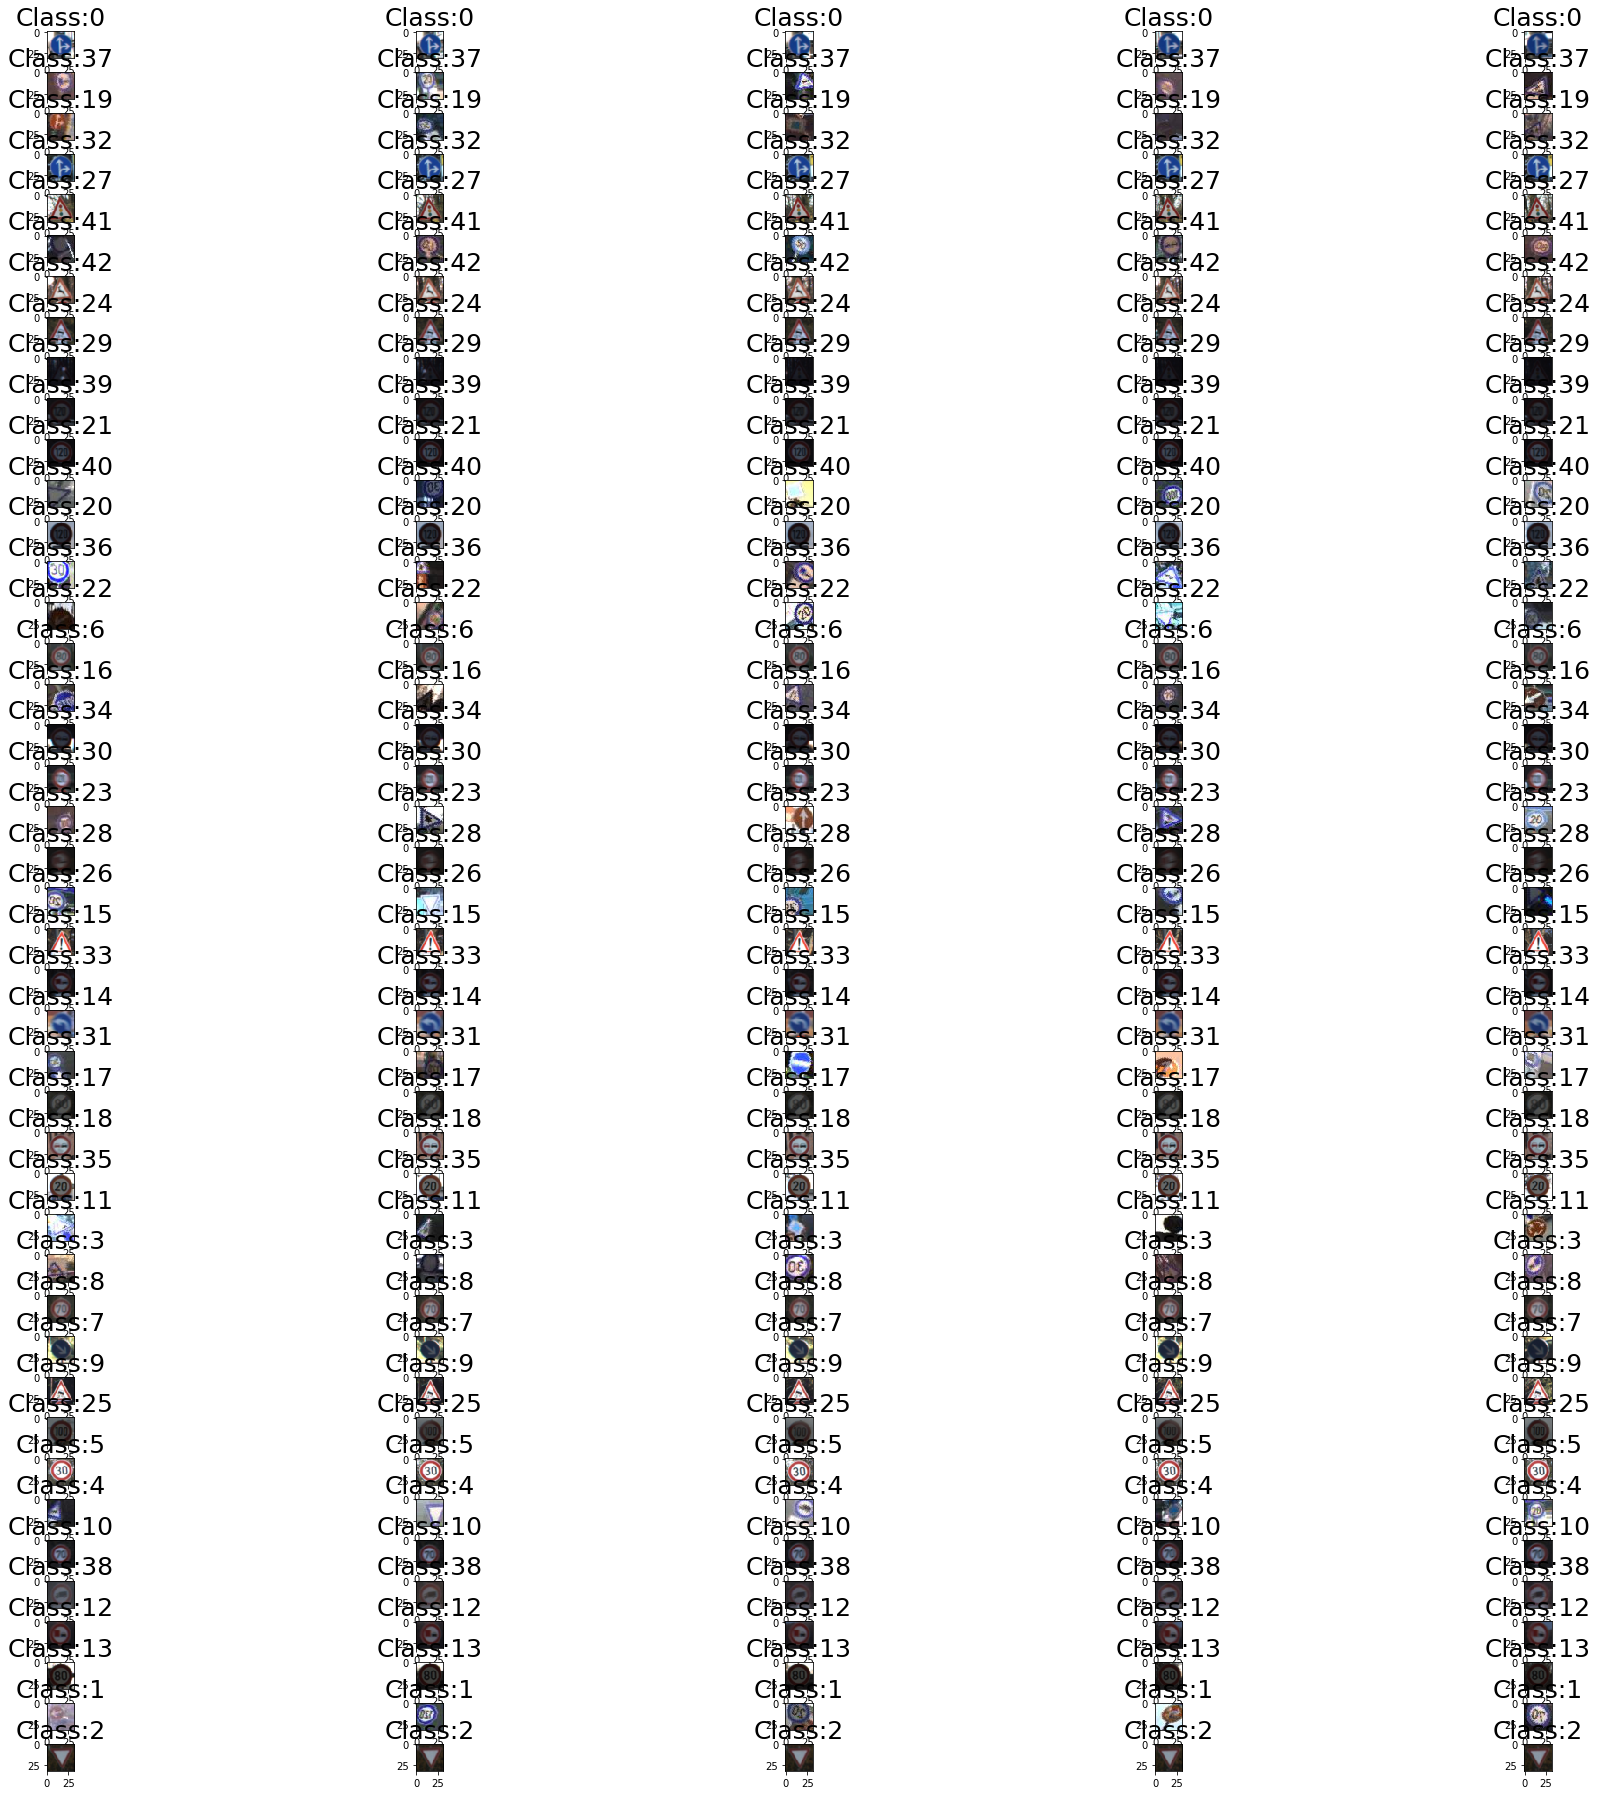

In [10]:
### Data processing/augmentation
import random 
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from math import ceil
import os
# Visualizations will be shown in the notebook.
%matplotlib inline
#X_train, y_train = shuffle(X_train, y_train)


print_batch = n_classes
start = random.randint(0, len(X_train) - print_batch)

u, indices, freq = np.unique(y_train, return_index=True, return_counts=True)
stacked = np.vstack((u, indices, freq))
combined = stacked[:,np.argsort(stacked[2])]

u = combined[0, :]
indices= combined[1, :]
freq = combined[2, :]

labels = np.array(y_train)[[indices]]
images = np.array(X_train)[[indices]]

#time-consuming processing/load operations
if not os.listdir('generated'):
    X_train, y_train, n_train = process_dataset(X_train, y_train, freq, indices, u,  extra_data_limit=700)
else: 
    X_train, y_train, n_train = load_extra_data(X_train, y_train)

f, axarr = plt.subplots(n_classes, 5, figsize=(32,32))
plt.figure()
f.subplots_adjust(hspace=.5)

for i in range(0, n_classes):    
    for j in range (5):
        subtitle = "Class:" + str(labels[i])
        axarr[i,j].set_title(subtitle, fontsize=25)
        axarr[i,j].imshow(X_train[indices[i] + j].squeeze())
        axarr[i,j].set_aspect(aspect=1, adjustable='box')

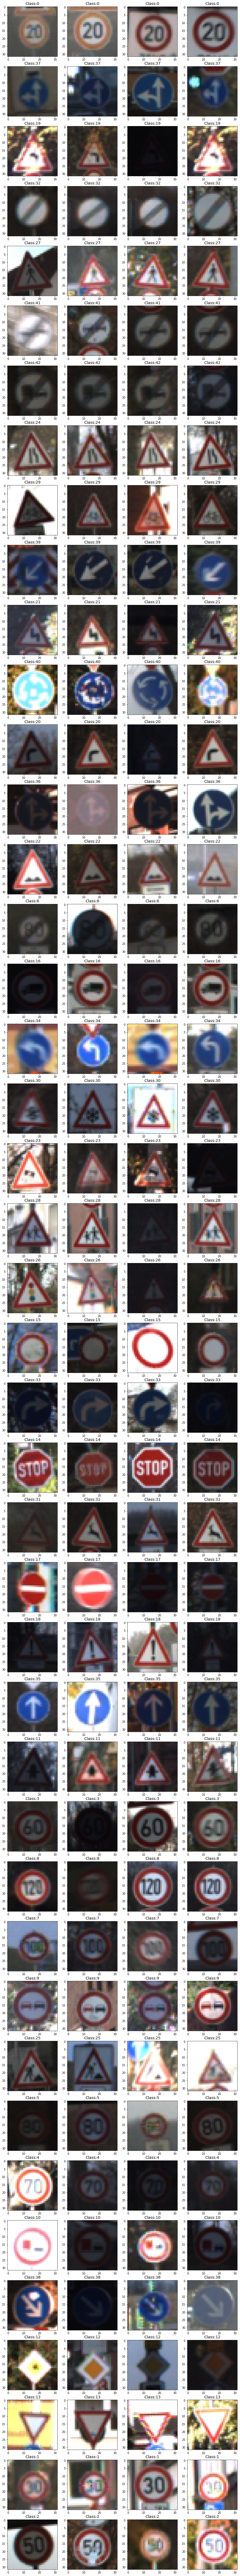

In [41]:
f, axarr = plt.subplots(n_classes, 4, figsize=(15,n_classes*4))
plt.figure()
fig.subplots_adjust(hspace = .4, wspace=.001)
#f.tight_layout()

for i in range(0, n_classes):    
    for j in range (4):
        randomIndex = np.random.randint(0, freq[i])
        subtitle = "Class:" + str(labels[i])
        axarr[i,j].set_title(subtitle, fontsize=14)
        axarr[i,j].set_aspect(aspect=1, adjustable='box')
        axarr[i,j].imshow(X_train[indices[i] + randomIndex])


In [ ]:


#visualizing preprocessed contrast normalized data set
X_data = equalize_data(X_train)
X_valid = equalize_data(X_valid)
X_test = equalize_data(X_test)
bins = range(n_classes)       
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(20, 10))

ax0.hist(y_train, bins,  histtype='stepfilled', facecolor='g')
ax0.set_title('Training Set Distribution')

# Create a histogram by providing the bin edges (unequally spaced).
ax1.hist(y_valid, bins, histtype='stepfilled', facecolor='y')
ax1.set_title('Validation Set Distribution')


# Create a histogram by providing the bin edges (unequally spaced).
ax2.hist(y_test, bins,  histtype='stepfilled', facecolor='r')
ax2.set_title('Test Set Distribution')

fig.tight_layout()
plt.show()
plt.close('all')

combined = stacked[:,np.argsort(stacked[0])]

#leave the relative distributions of the signs the same -> biases the model to pick the sign with higher frequency 
#in the training set at times of uncertainty


# ----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [ ]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle
 
X_train, y_train = shuffle(X_train, y_train)

X_train = ( X_train - 128 ) / 128
X_valid = ( X_valid - 128 ) / 128 
X_test = ( X_test - 128 ) / 128

### Model Architecture

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

EPOCHS = 30
BATCH_SIZE = 128

from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
    
    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    tf.nn.dropout(fc2, keep_prob=0.5)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, tf.cast(n_classes, tf.int32))


### Train, Validate and Test the Model

# A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [ ]:
### Train your model here.
rate = 0.001

#batch_x_test, batch_y_test = create_train_batch(X_train[0:2], y_train[0:2], 2)
#f, axarr = plt.subplots(20,1 , figsize=(32,32))
#plt.figure()
#f.subplots_adjust(hspace=.5)
#y_index = 0
#for i in range(20):    
#    subtitle = "Class:" + str(batch_y_test[i]) 
#    axarr[i].set_title(subtitle, fontsize=25)
#    axarr[i].imshow(batch_x_test[i].squeeze())
#    axarr[i].set_aspect(aspect=1, adjustable='box') 

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Calculate and report the accuracy on the training and validation set.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * BATCH_SIZE)
    return total_accuracy / (num_examples)

### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            #if end < num_examples:
            #    batch_x, batch_y = create_train_batch(X_train[offset:end], y_train[offset:end],BATCH_SIZE, extra_data_per_element=4)
            #else: 
            #    batch_x, batch_y = create_train_batch(X_train[offset:end], y_train[offset:offset+BATCH_SIZE], num_examples - offset, extra_data_per_element=4)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")



### Feel free to use as many code cells as needed.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


# Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")